In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr

from typing import Sequence, Optional, Union

import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

from collections import namedtuple

import torchsde

#for plotting
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# ERA5 Data: Temperature (t), Wind Speed (ws), Geopotential (z) at 1000hPa height

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


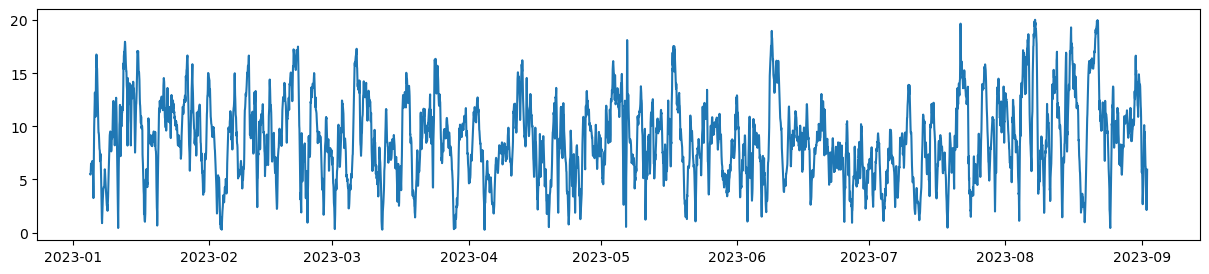

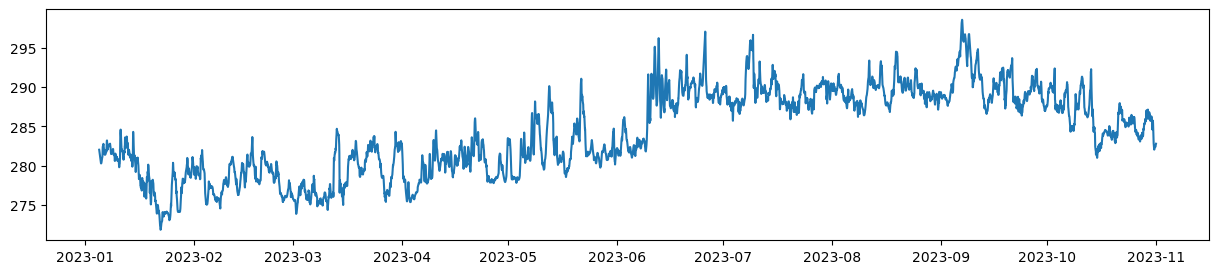

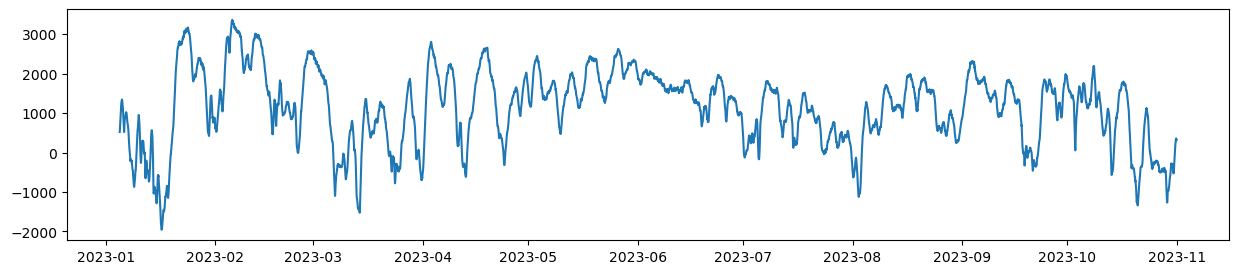

In [2]:
ft = xr.open_dataset('dataset_T_2023_1000hPa.nc')
t100 = ft.variables['t'][:,:,:] # temperature
t100_data = np.array(t100)


fgp = xr.open_dataset('dataset_GP_2023_1000hPa.nc')
z100 = fgp.variables['z'][:,:,:] # geopotential
z100_data = np.array(z100)


f = xr.open_dataset('dataset_2012-2023_1000hPa.nc')
lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u'][:,:,:,0] # u-wind 
v100 = f.variables['v'][:,:,:,0]  # v-wind 
time = f.variables['time'][:] # time


ws100_data = np.array(np.sqrt(u100*u100+v100*v100)) #wind speed


nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
ws100 = ws100_data[nan_idx,:,:]
time_vec = time[nan_idx]


plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],ws100_data[-24*300:,2,2])
plt.title('Timeseries of wind speed [m/s]')

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],t100_data[-24*300:,2,2])
plt.title('Timeseries of temperature [K]')

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],z100_data[-24*300:,2,2])
plt.title('Timeseries of geopotential [m^2/s^2]')





In [3]:
ws_ly = ws100[-24*301:,:,:]
t_ly = t100_data[-24*301:,:,:]
z_ly = z100_data[-24*301:,:,:]

# Neural SDE for historical weather data based on Scaleable Gradients for SDEs by Li et al. (2020)

In [21]:

class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


#Encoder 
# https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out


class LatentSDE(nn.Module):
    # stochastic ito integral
    sde_type = "ito"
    # diffusion is element wise 
    noise_type = "diagonal" 

    def __init__(self, data_size, latent_size, context_size, hidden_size):
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        # corresponding (posterior) drift
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # corresponding to prior drift to calculate KL divergence (section 5 in Scalable Gradients for SDEs by Li et al., 2020) to reduce overfitting
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # Diffusion: This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  

    def f(self, t, y): # (posterior) Drift 
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y): # (prior) Drift
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=False, method="midpoint"):
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs



In [22]:
# Parameters
batch_size=8#512#1024
latent_size=4
context_size=8
hidden_size=8#2#128
lr_init=1e-2
t0=0.
t1=25.
lr_gamma=0.997
kl_anneal_iters=1000
pause_every=1
noise_std=0.1
adjoint=False
train_dir='./'
method="milstein"

num_samples=batch_size

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
xs = torch.empty((25, 8, 3), dtype=torch.float32)
ts = torch.empty(25, dtype=torch.float32)

In [25]:
# select some coordinates and short range from time series
xcoord = 8
ycoord = 1

ws_mean = np.mean(ws_ly[21,0:xcoord,:ycoord])
ws_std = np.std(ws_ly[21,0:xcoord,:ycoord])
t_mean = np.mean(t_ly[21,0:xcoord,:ycoord])
t_std = np.std(t_ly[21,0:xcoord,:ycoord])
z_mean = np.mean(z_ly[21,0:xcoord,:ycoord])
z_std = np.std(z_ly[21,0:xcoord,:ycoord])

ws_ly = (ws_ly-ws_mean)/ws_std
t_ly = (t_ly-t_mean)/t_std
z_ly = (z_ly-z_mean)/z_std

ws_test = torch.tensor(ws_ly[21:46,0:xcoord,:ycoord])
temp_test = torch.tensor(t_ly[21:46,0:xcoord,:ycoord])
gp_test = torch.tensor(t_ly[21:46,0:xcoord,:ycoord])



for i in range(25):
    ts[i] = float(i)
    for j in range(xcoord):
        for k in range(ycoord):
            #plt.plot(temp_test[0:25,j,k])
            xs[i,j+k,0] = ws_test[i,j,k]
            xs[i,j+k,1] = temp_test[i,j,k]
            xs[i,j+k,2] = gp_test[i,j,k]

In [26]:

latent_sde = LatentSDE(
        data_size=3,
        latent_size=latent_size,
        context_size=context_size,
        hidden_size=hidden_size,
    ).to(device)

optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_gamma)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=t1, size=(batch_size, latent_size,), device=device, levy_area_approximation="space-time")

In [27]:
num_iters = 20000
for global_step in tqdm.tqdm(range(1, num_iters + 1)):
    latent_sde.zero_grad()
    log_pxs, log_ratio = latent_sde(xs, ts, noise_std, adjoint, method)
    loss = -log_pxs + log_ratio * kl_scheduler.val
    loss.backward()
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()



    

 71%|███████   | 14190/20000 [17:38<07:26, 13.01it/s] 

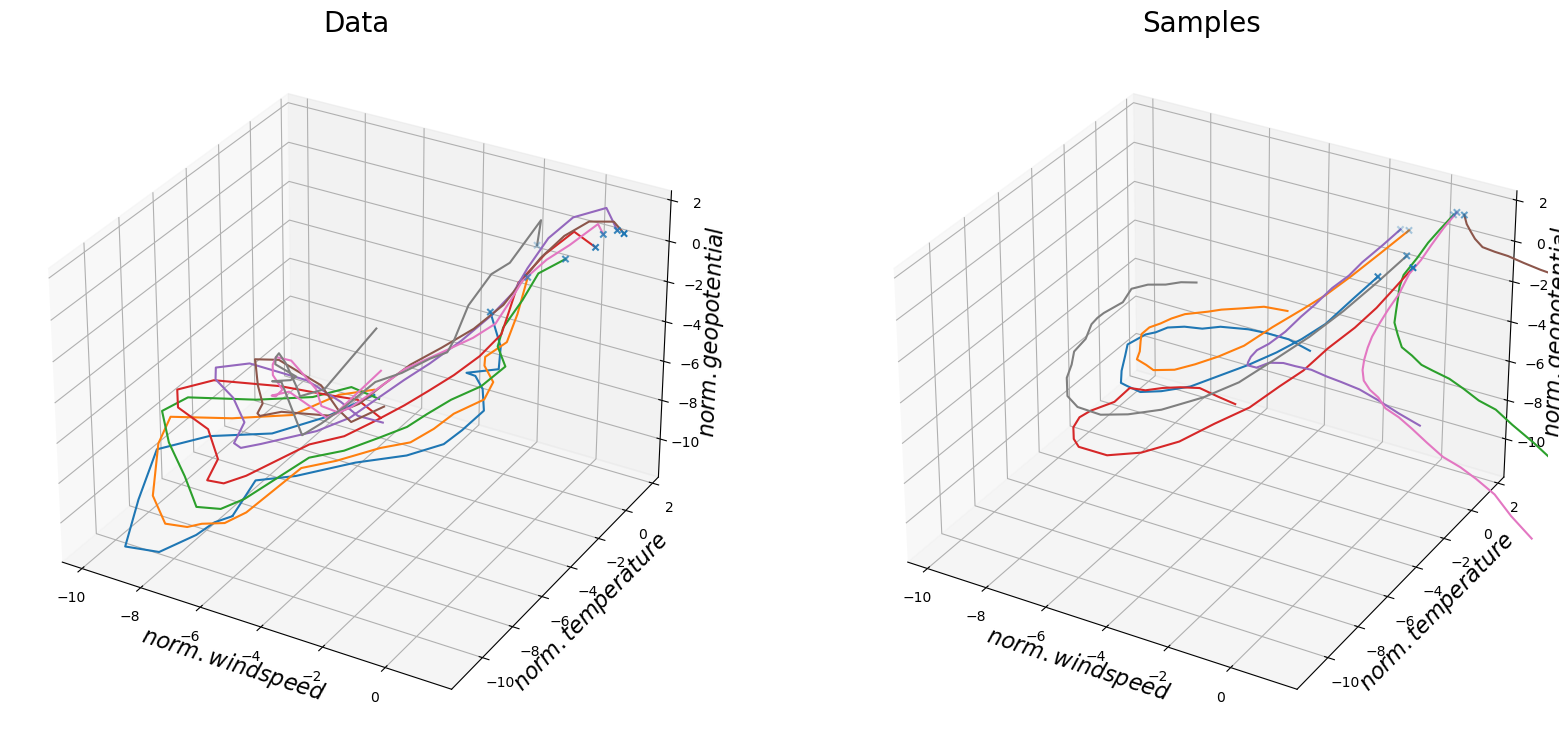

In [18]:
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
ax00.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

# Right plot: model.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
ax01.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax01.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()